# Get Sephora locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import os
import requests
import json

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
import us

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

---

## Scrape

#### Headers for requests

In [184]:
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"
}

#### Read store list page

In [185]:
url = "https://www.sephora.com/happening/storelist"
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

#### Find all the location link and store in a list

In [186]:
places_list = []

for l in soup.findAll("a", class_="css-aq2dcf eanm77i0"):
    places_dict = {"location": l.text, "url": "https://www.sephora.com" + l["href"]}
    places_list.append(places_dict)

In [187]:
places_df = pd.DataFrame(places_list)

#### Loop through places list, gathering store details from inline json

In [190]:
store_detail_list = []

for u in tqdm(places_df["url"].unique()):
    response = requests.get(u, headers=headers)
    html = BeautifulSoup(response.text, "html.parser")
    data = json.loads(html.findAll("script", id="linkStore")[0].text)
    store_details_dict = {
        "store_id": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["storeId"],
        "latitude": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["latitude"],
        "longitude": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["longitude"],
        "address": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["address"]["address1"],
        "address2": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["address"]["address2"],
        "city": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"]["stores"][
            0
        ]["address"]["city"],
        "zip_code": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["address"]["postalCode"],
        "state": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["address"]["state"],
        "mall_name": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["address"]["mallName"],
        "phone": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["address"]["phone"],
        "time_zone": data["ssrProps"]["ErrorBoundary(ReduxProvider(StoreDetail))"][
            "stores"
        ][0]["storeHours"]["timeZone"],
        "url": u,
    }

    store_detail_list.append(store_details_dict)

  0%|          | 0/1593 [00:00<?, ?it/s]

#### Read list of store dictionaries into a dataframe

In [196]:
df = pd.DataFrame(store_detail_list)

#### The result:

In [197]:
df.head()

,store_id,latitude,longitude,address,address2,city,zip_code,state,mall_name,phone,time_zone,url
0,0124,33.4470,-86.72600,205 Summit Blvd,Suite 300,Birmingham,35243,AL,The Summit,(205)969-4848,CST6CDT,https://www.sephora.com/happening/stores/birmingham-the-summit
1,0724,34.7170,-86.67400,335 The Bridge St,Suite 117,Huntsville,35806,AL,,(256) 327-8737,CST6CDT,https://www.sephora.com/happening/stores/huntsville
2,1764,32.3585,-86.16717,7064 EastChase Parkway,Suite: C180,Montgomery,36117,AL,,(334) 229-9022,CST6CDT,https://www.sephora.com/happening/stores/shoppes-at-eastchase
3,0788,61.2170,-149.88800,320 W. 5th Ave,Space #201,Anchorage,99501,AK,,(907) 277-7700,America/Anchorage,https://www.sephora.com/happening/stores/anchorage-5th-ave-mall
4,0288,33.3010,-111.89800,3111 W. Chandler Blvd,Space 1144,Chandler,85226,AZ,Chandler Fashion Center,(480) 726-7733,MST,https://www.sephora.com/happening/stores/chandler-fashion-center


#### How many in California?

In [195]:
len(df.query('state=="CA"'))

---

## Geography

#### Geodataframe from lon/lat

In [214]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

In [215]:
gdf = gdf.query("latitude>0")

#### Plot it

<AxesSubplot: >

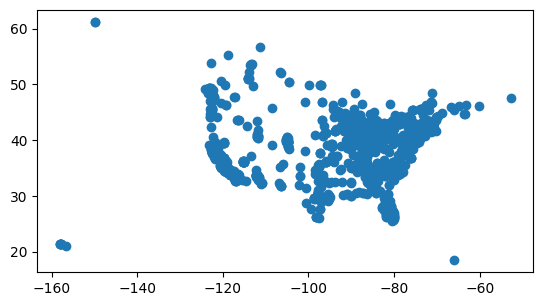

In [216]:
gdf.plot()

In [217]:
df = df.drop(["geometry"], axis=1)

---

## Exports

In [218]:
gdf.to_file("data/processed/sephora.geojson", driver="GeoJSON")

In [219]:
df.to_json("data/processed/sephora.json", orient="records", indent=4)

In [220]:
df.to_csv("data/processed/sephora.csv", index=False)